In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import Counter

In [355]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train = train[test.columns]

accident = pd.read_csv("./data/external_open/countrywide_accident.csv")
CCTV = pd.read_csv("./data/external_open/대구CCTV정보.csv", encoding='cp949')
light = pd.read_csv("./data/external_open/대구보안등정보.csv", encoding='cp949')
child = pd.read_csv("./data/external_open/대구어린이보호구역정보.csv", encoding='cp949')
parking = pd.read_csv("./data/external_open/대구주차장정보.csv", encoding='cp949')


C:\Users\Ryzen\AppData\Local\Temp\ipykernel_1876\2916042668.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  light = pd.read_csv("./data/external_open/대구보안등정보.csv", encoding='cp949')


In [264]:
CCTV

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,대구광역시 북구 구암동 671-8,35.925294,128.552023,구암고교교차로(면허시험장삼거리→구암역),2,40,NaN,NaN,99.0,2021.0
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,대구광역시 북구 사수동 812,35.900977,128.513825,사수초교앞(삼영초교→사수중학교),2,30,NaN,NaN,2.0,2021.0
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,대구광역시 북구 대현동 270-8,35.882191,128.609791,신암초교 남측(공고R)(경대교→공고네거리),2,30,NaN,NaN,2.0,2021.0
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,대구광역시 북구 대현동 270-3,35.881737,128.611651,신암초교 남측(경대교)(공고네거리→경대교),2,30,NaN,NaN,2.0,2021.0


In [258]:
# 피하자의 정보에 Na 값이 있는 것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
dtypes: object(8)
memory usage: 2.4+ MB


In [354]:
# 카메라 관리번호는 이름이므로 영향이 없을거라 판단
# 시도명은 전부 대구광역시이므로 삭제
# 시군구명은 소재지지번주소에 포함되어있으므로 삭제
# 도로노선명은 소재지지번주소로 표현이 가능하다 판단해 삭제 -> train 데이터와 결합할 때 지번주소를 사용할 예정이므로 필요가 없음
# 위도와 경도는 정확한 위치 정보이므로 소재재지번주소로 대체
# 설치장소는 소재지지번주소로 대체
CCTV = CCTV[["도로노선방향", "도로종류", "소재지지번주소", "단속구분", "제한속도", "단속구간위치구분", "과속단속구간길이", "보호구역구분", "설치연도"]]
CCTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   도로노선방향    1065 non-null   int64  
 1   도로종류      1065 non-null   object 
 2   소재지지번주소   1063 non-null   object 
 3   단속구분      1065 non-null   int64  
 4   제한속도      1065 non-null   int64  
 5   단속구간위치구분  53 non-null     float64
 6   과속단속구간길이  26 non-null     float64
 7   보호구역구분    893 non-null    float64
 8   설치연도      1065 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 75.0+ KB


In [260]:
# 보안등위치명은 소재지지번주소로 대체
# 소재지도로명주소, 위도와 경도는 지번주소를 사용할 것이므로 삭제
light = light[["설치개수","소재지지번주소", "설치연도", "설치형태"]]
light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   설치개수     71913 non-null  int64  
 1   소재지지번주소  71913 non-null  object 
 2   설치연도     29397 non-null  float64
 3   설치형태     35373 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.2+ MB


In [261]:
# 대상시설명, 소재지도로명주소, 위도, 경도는 소재지지번주소로 대체
# 관리기관명과 관할경찰서명은 주소에 따라 다르고 예측에 영향을 주지 않을 것이라 판단
child = child[["시설종류", "소재지지번주소","CCTV설치여부","CCTV설치대수","보호구역도로폭"]]
child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   소재지지번주소   555 non-null    object 
 2   CCTV설치여부  640 non-null    object 
 3   CCTV설치대수  465 non-null    float64
 4   보호구역도로폭   320 non-null    object 
dtypes: float64(1), object(4)
memory usage: 25.1+ KB


In [262]:
# 관리번호, 주차장명, 소재지도로명주소, 결제방법, 특기사항, 위도, 경도 삭제
parking = parking[['주차장구분', '주차장유형',  '소재지지번주소', '주차구획수', '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금']]
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주차장구분        871 non-null    object 
 1   주차장유형        871 non-null    object 
 2   소재지지번주소      775 non-null    object 
 3   주차구획수        871 non-null    int64  
 4   급지구분         871 non-null    int64  
 5   부제시행구분       871 non-null    object 
 6   운영요일         871 non-null    object 
 7   평일운영시작시각     871 non-null    object 
 8   평일운영종료시각     871 non-null    object 
 9   토요일운영시작시각    871 non-null    object 
 10  토요일운영종료시각    871 non-null    object 
 11  공휴일운영시작시각    871 non-null    object 
 12  공휴일운영종료시각    871 non-null    object 
 13  요금정보         871 non-null    object 
 14  주차기본시간       871 non-null    int64  
 15  주차기본요금       871 non-null    int64  
 16  추가단위시간       298 non-null    float64
 17  추가단위요금       298 non-null    float64
 18  1일주차권요금적용시간  139 non-null    float64
 19  1일주차권요금 

# EDA

### 1. 데이터 구성 변경

In [244]:
train_new = train.copy()

# ID 삭제
train_new = train_new.drop(["ID"], axis = 1)

# Hour 변수 추가
train_new["Hour"] = [i.split()[1] for i in train_new.사고일시]
train_new["사고일시"] = [i.split()[0] for i in train_new.사고일시]

# Year, Month, Day 변수 추가
train_new["Year"] = [i.split("-")[0] for i in train_new.사고일시]
train_new["Month"] = [i.split("-")[1] for i in train_new.사고일시]
train_new["Day"] = [i.split("-")[2] for i in train_new.사고일시]
train_new["Year_Month"] = [train_new.Year[i] + train_new.Month[i] for i in range(len(train_new))]
train_new = train_new.drop(["사고일시"], axis = 1)

# 시군구 분리
train_new["군"] = [i.split(" ")[1] for i in train_new.시군구]
train_new["구"] = [i.split(" ")[2] for i in train_new.시군구]
train_new = train_new.drop(["시군구"], axis = 1)

# 도로형태 분리
train_new["도로형태대분류"] = [i.split("-")[0] for i in train_new.도로형태]
train_new["도로형태소분류"] = [i.split("-")[1] for i in train_new.도로형태]
train_new = train_new.drop(["도로형태"], axis = 1)

In [245]:
train_new

,요일,기상상태,노면상태,사고유형,Hour,Year,Month,Day,Year_Month,군,구,도로형태대분류,도로형태소분류
0,화요일,맑음,건조,차대사람,00,2019,01,01,201901,중구,대신동,단일로,기타
1,화요일,흐림,건조,차대사람,00,2019,01,01,201901,달서구,감삼동,단일로,기타
2,화요일,맑음,건조,차대사람,01,2019,01,01,201901,수성구,두산동,단일로,기타
3,화요일,맑음,건조,차대차,02,2019,01,01,201901,북구,복현동,단일로,기타
4,화요일,맑음,건조,차대차,04,2019,01,01,201901,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,19,2021,12,31,202112,수성구,수성동3가,교차로,교차로안
39605,금요일,맑음,건조,차대차,19,2021,12,31,202112,달서구,상인동,단일로,기타
39606,금요일,맑음,건조,차대차,21,2021,12,31,202112,달서구,월성동,교차로,교차로안
39607,금요일,맑음,건조,차대차,22,2021,12,31,202112,달서구,장동,기타,기타


In [350]:
CCTV["구"] = [i.split()[2] if type(i) == str else i for i in CCTV.소재지지번주소]
CCTV = CCTV.drop(["소재지지번주소"], axis = 1)

# train 데이터의 사고가 난 시군구 노선방향, 도로종류, 단속구간위치구분, 과속단속구간길이는 
# 보호구역 여부
CCTV["어린이보호구역"] = [1 if i == 2 else 0 for i in CCTV.보호구역구분]
CCTV["노인보호구역"] = [1 if i == 1 else 0 for i in CCTV.보호구역구분]
CCTV["기타보호구역"] = [1 if i == 99 else 0 for i in CCTV.보호구역구분]

# 단속구분
CCTV["속도단속"] = [1 if i == 1 else 0 for i in CCTV.단속구분]
CCTV["신호단속"] = [1 if i == 2 else 0 for i in CCTV.단속구분]
CCTV["통행위반"] = [1 if i == 3 else 0 for i in CCTV.단속구분]
CCTV["불법주정차"] = [1 if i == 4 else 0 for i in CCTV.단속구분]
CCTV["기타단속"] = [1 if i == 99 else 0 for i in CCTV.단속구분]

CCTV = CCTV[['설치연도', '구', '어린이보호구역', '노인보호구역', '기타보호구역', '속도단속', '신호단속', '통행위반',
       '불법주정차', '기타단속']]

CCTV

,설치연도,구,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속
0,2010.0,대명동,0,0,1,0,0,0,1,0
1,2013.0,봉덕동,0,0,1,0,0,0,1,0
2,2013.0,봉덕동,0,0,1,0,0,0,1,0
3,2014.0,대명동,0,0,1,0,0,0,1,0
4,2014.0,봉덕동,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1060,2021.0,구암동,0,0,1,0,1,0,0,0
1061,2021.0,사수동,1,0,0,0,1,0,0,0
1062,2021.0,대현동,1,0,0,0,1,0,0,0
1063,2021.0,대현동,1,0,0,0,1,0,0,0


In [356]:
CCTV["구"] = [i.split()[2] if type(i) == str else i for i in CCTV.소재지지번주소]

In [341]:
[i for i in train_new.구 if len(re.findall(r"[0-9]동$",i))==1]

[]

In [347]:
len(re.findall(r"가$","대명가"))

1

In [345]:
CCTV.구[0]

'대명동'

In [359]:
"종로1가" in train_new.구.tolist()


True

In [357]:
CCTV[CCTV.구.isna()]

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,구
328,10,대구광역시,중구,구도,NaN,종로,3,대구광역시 중구 종로 17,NaN,35.867602,128.592078,남성로 정관장앞,4,0,NaN,NaN,NaN,2009.0,NaN
738,G8181,대구광역시,중구,특별시도,NaN,국채보상로,2,대구광역시 중구 국채보상로 713,NaN,35.868862,128.608593,동인초교건너(동신교차로→종각네거리),2,50,NaN,NaN,99.0,2020.0,NaN


In [342]:
[i for i in CCTV.구 if len(re.findall(r"가$",i))==1]

TypeError: expected string or bytes-like object, got 'float'

In [247]:
# 사고 날짜는 정확한데 CCTV 설치날짜는 세세하지않고 연도만 나와있음
# train 데이터는 2019년의 경우 2018년 이전 CCTV 갯수만 반영, 2020년의 경우 2019년 이전 CCTV 갯수만 반영한다.
def df_add(row, df2):
    if row.구 in df2.구.tolist():
        row[row.index.drop(["구"])] += df2.iloc[df2.구.tolist().index(row.구)][df2.columns.drop(["구"])]
    return row

CCTV_2018_before = CCTV[CCTV.설치연도 < 2019]
CCTV_2019 = CCTV[CCTV.설치연도 == 2019]
CCTV_2020 = CCTV[CCTV.설치연도 == 2020]
CCTV_2021 = CCTV[CCTV.설치연도 == 2021]

CCTV_2018_before = CCTV_2018_before.groupby("구").sum()
CCTV_2018_before = CCTV_2018_before.reset_index()
CCTV_2018_before = CCTV_2018_before.drop(["설치연도"], axis = 1)

CCTV_2019 = CCTV_2019.groupby("구").sum()
CCTV_2019 = CCTV_2019.reset_index()
CCTV_2019 = CCTV_2019.drop(["설치연도"], axis = 1)

CCTV_2020 = CCTV_2020.groupby("구").sum()
CCTV_2020 = CCTV_2020.reset_index()
CCTV_2020 = CCTV_2020.drop(["설치연도"], axis = 1)

CCTV_2021 = CCTV_2021.groupby("구").sum()
CCTV_2021 = CCTV_2021.reset_index()
CCTV_2021 = CCTV_2021.drop(["설치연도"], axis = 1)

CCTV_2019_Total = CCTV_2018_before.copy()

CCTV_2020_Total = pd.DataFrame()
CCTV_2020_Total["구"] = list(set(CCTV_2018_before.구.tolist())|set(CCTV_2019.구.tolist()))
CCTV_2020_Total[CCTV_2019.columns.drop(["구"])] = 0
CCTV_2020_Total = CCTV_2020_Total.apply(lambda x : df_add(x, CCTV_2018_before), axis = 1)
CCTV_2020_Total = CCTV_2020_Total.apply(lambda x : df_add(x, CCTV_2019), axis = 1)

CCTV_2021_Total = pd.DataFrame()
CCTV_2021_Total["구"] = list(set(CCTV_2020_Total.구.tolist())|set(CCTV_2020.구.tolist()))
CCTV_2021_Total[CCTV_2020.columns.drop(["구"])] = 0
CCTV_2021_Total = CCTV_2021_Total.apply(lambda x : df_add(x, CCTV_2020_Total), axis = 1)
CCTV_2021_Total = CCTV_2021_Total.apply(lambda x : df_add(x, CCTV_2020), axis = 1)

CCTV_2022_Total = pd.DataFrame()
CCTV_2022_Total["구"] = list(set(CCTV_2021_Total.구.tolist())|set(CCTV_2021.구.tolist()))
CCTV_2022_Total[CCTV_2021.columns.drop(["구"])] = 0
CCTV_2022_Total = CCTV_2022_Total.apply(lambda x : df_add(x, CCTV_2021_Total), axis = 1)
CCTV_2022_Total = CCTV_2022_Total.apply(lambda x : df_add(x, CCTV_2021), axis = 1)

CCTV_2019_Total["Year"] = "2019"
CCTV_2020_Total["Year"] = "2020"
CCTV_2021_Total["Year"] = "2021"
CCTV_2022_Total["Year"] = "2022"
CCTV_Total = pd.concat([CCTV_2019_Total, CCTV_2020_Total, CCTV_2021_Total, CCTV_2022_Total])

train_new = pd.merge(train_new, CCTV_Total, how = "left", on = ["구", "Year"])
train_new = train_new.fillna(0)

In [276]:
CCTV_2021

,구,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속
0,가창면,2,0,2,4,2,0,0,0
1,각산동,1,0,0,0,1,0,0,0
2,감삼동,1,0,0,0,0,0,1,0
3,검단동,0,0,2,0,2,0,0,0
4,관음동,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
94,호산동,2,0,0,0,1,0,1,0
95,화원읍,8,0,0,4,4,0,0,0
96,황금동,0,0,2,1,1,0,0,0
97,효령면,2,0,1,3,0,0,0,0


In [338]:
re.findall(r"가$","가서야")

[]

In [340]:
import re
[i for i in CCTV_2021_Total.구 if len(re.findall(r"[0-9]동$",i))==1]

[]

In [301]:
"비산동" in train_new.구.tolist()


True

In [302]:
CCTV_2021_Total.구

0         서야동
1         송현동
2         본리동
3      두류1.2동
4         범어동
        ...  
154     계산동2가
155       삼산리
156       평리동
157       신당동
158       월성동
Name: 구, Length: 159, dtype: object

In [285]:
set(CCTV_2021_Total.구) - set(train_new.구)

{'군위읍',
 '남리',
 '남산동912-5',
 '두류1.2동',
 '매곡리',
 '부계면',
 '북리',
 '비산2.3동',
 '비산4동',
 '삼산리',
 '세천리',
 '소보면',
 '신안동',
 '신암1동',
 '신암4동',
 '용계리',
 '우보면',
 '의흥면',
 '정대리',
 '침산2동',
 '평리4동',
 '하리',
 '현풍면',
 '효령면'}

In [286]:
set(train_new.구) - set(CCTV_2021_Total.구)

{'검단동',
 '검사동',
 '계산동1가',
 '고성동1가',
 '고성동2가',
 '교동',
 '금강동',
 '남성로',
 '내동',
 '노곡동',
 '노변동',
 '능성동',
 '달성동',
 '대림동',
 '대안동',
 '대흥동',
 '덕산동',
 '도남동',
 '동내동',
 '동문동',
 '동변동',
 '동성로1가',
 '동인동1가',
 '동일동',
 '둔산동',
 '매여동',
 '부동',
 '불로동',
 '사월동',
 '사일동',
 '상리동',
 '상매동',
 '상서동',
 '서문로1가',
 '서문로2가',
 '서성로1가',
 '서호동',
 '성동',
 '송정동',
 '숙천동',
 '시장북로',
 '신무동',
 '신용동',
 '연경동',
 '연호동',
 '완전동',
 '용수동',
 '욱수동',
 '원대동2가',
 '원대동3가',
 '장관동',
 '장동',
 '전동',
 '종로2가',
 '중대동',
 '진인동',
 '태평로2가',
 '포정동',
 '하서동',
 '향촌동',
 '화전동'}

In [280]:
"원대동1가" in train_new.구.tolist()


True

In [250]:
train_new = train_new.fillna(0)

In [60]:
train_new[train_new.Year >= "2020"]

,요일,기상상태,노면상태,사고유형,Hour,Year,Month,Day,Year_Month,군,...,도로형태대분류,도로형태소분류,어린이보호구역,노인보호구역,기타보호구역,속도단속,신호단속,통행위반,불법주정차,기타단속
14536,수요일,맑음,건조,차대차,00,2020,01,01,202001,달서구,...,단일로,기타,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14537,수요일,맑음,건조,차대차,02,2020,01,01,202001,달서구,...,교차로,교차로안,2.0,0.0,2.0,0.0,2.0,0.0,8.0,0.0
14538,수요일,맑음,건조,차대차,05,2020,01,01,202001,북구,...,교차로,교차로부근,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
14539,수요일,맑음,건조,차대사람,05,2020,01,01,202001,중구,...,단일로,기타,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
14540,수요일,맑음,건조,차대차,06,2020,01,01,202001,수성구,...,단일로,기타,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,19,2021,12,31,202112,수성구,...,교차로,교차로안,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39605,금요일,맑음,건조,차대차,19,2021,12,31,202112,달서구,...,단일로,기타,4.0,0.0,5.0,1.0,3.0,0.0,8.0,3.0
39606,금요일,맑음,건조,차대차,21,2021,12,31,202112,달서구,...,교차로,교차로안,4.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0
39607,금요일,맑음,건조,차대차,22,2021,12,31,202112,달서구,...,기타,기타,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 범주형 변수 전부 라벨링
for column in ['요일', '기상상태', '노면상태', '사고유형', 'Hour', 'Year', 'Month', 'Day',
       'Year_Month', '군', '구', '도로형태대분류', '도로형태소분류']:
    le = LabelEncoder()
    le.fit(train_new[column])
    train_new[column] = le.transform(train_new[column])


In [12]:
train_new.corr()

,요일,기상상태,노면상태,사고유형,Hour,Year,Month,Day,Year_Month,군,구,도로형태대분류,도로형태소분류
요일,1.000000,0.003608,0.012741,0.012525,-0.026245,-0.013370,-0.002333,-0.000638,-0.013473,0.004704,0.003835,0.000286,-0.003977
기상상태,0.003608,1.000000,0.625393,0.000596,0.015927,0.033193,-0.014193,-0.002997,0.026865,-0.019706,-0.013162,-0.011305,-0.014973
노면상태,0.012741,0.625393,1.000000,0.011265,0.023081,0.026779,-0.021993,-0.015968,0.018201,-0.002773,-0.013411,-0.011948,-0.019096
사고유형,0.012525,0.000596,0.011265,1.000000,-0.027992,0.008726,0.002244,-0.002935,0.009031,-0.004898,0.012261,-0.058458,-0.111093
Hour,-0.026245,0.015927,0.023081,-0.027992,1.000000,0.012290,-0.006122,0.003374,0.009662,-0.022173,0.001661,0.003752,0.003917
Year,-0.013370,0.033193,0.026779,0.008726,0.012290,1.000000,-0.018267,-0.012228,0.944205,-0.002591,0.009264,-0.000850,-0.004246
Month,-0.002333,-0.014193,-0.021993,0.002244,-0.006122,-0.018267,1.000000,0.008078,0.312055,-0.006088,0.005751,0.001454,0.001042
Day,-0.000638,-0.002997,-0.015968,-0.002935,0.003374,-0.012228,0.008078,1.000000,-0.008958,0.004423,0.002965,0.002750,0.001336
Year_Month,-0.013473,0.026865,0.018201,0.009031,0.009662,0.944205,0.312055,-0.008958,1.000000,-0.004468,0.010697,-0.000329,-0.003692
군,0.004704,-0.019706,-0.002773,-0.004898,-0.022173,-0.002591,-0.006088,0.004423,-0.004468,1.000000,-0.000173,0.027900,0.000638


<Axes: >

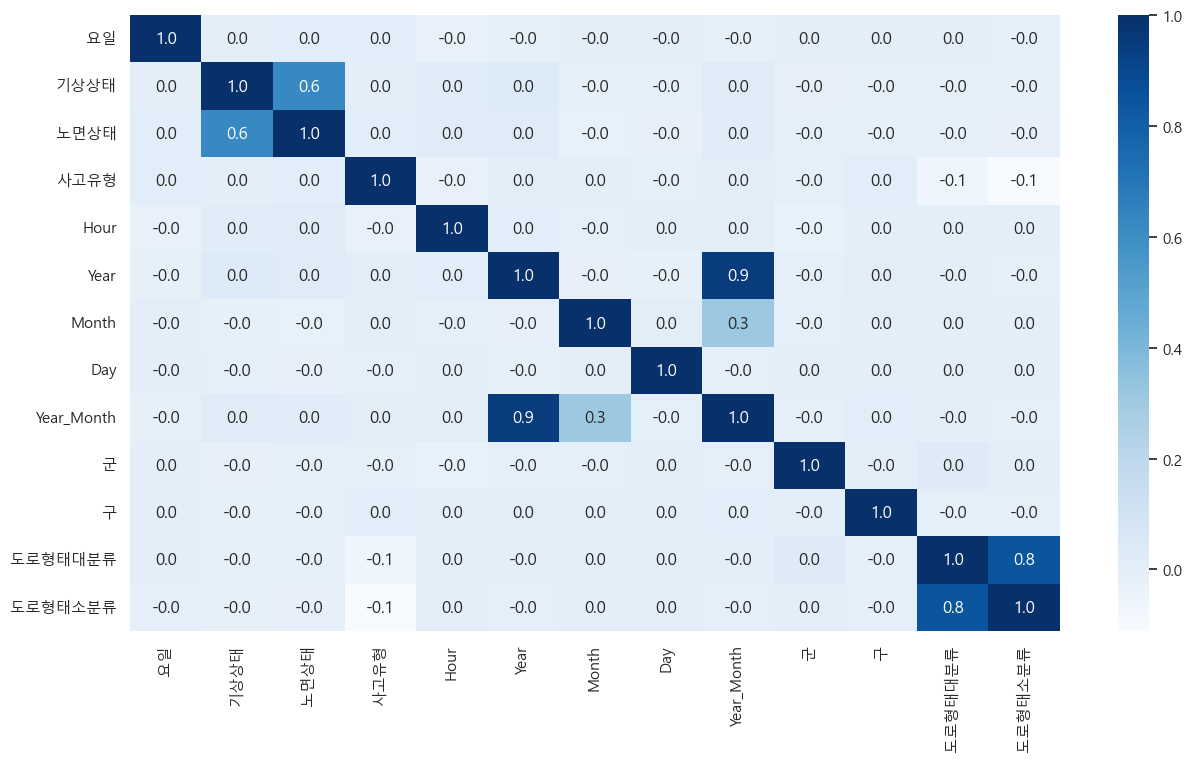

In [13]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
sns.heatmap(train_new.corr(), annot = True, fmt = ".1f", cmap="Blues")

In [62]:
train_new

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,Year,Month,Day,Total
0,6,2,155,6,0,0,2,7,5,2,...,0,1,0,0,5,0,0,0,0,1
1,6,5,4,6,0,0,5,2,5,1,...,0,0,1,0,3,0,0,0,0,1
2,6,2,124,6,0,0,9,7,5,1,...,0,0,1,0,3,1,0,0,0,1
3,6,2,98,6,0,1,10,7,5,1,...,0,1,0,0,5,2,0,0,0,1
4,6,2,65,6,0,1,10,7,5,1,...,0,0,1,0,3,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,135,1,0,1,11,5,5,2,...,0,0,1,0,3,19,2,11,30,1
39605,0,2,11,6,0,1,11,6,5,2,...,0,0,1,0,3,19,2,11,30,1
39606,0,2,16,1,0,1,11,1,5,1,...,0,2,0,0,10,21,2,11,30,2
39607,0,2,21,3,0,1,10,7,5,1,...,0,0,1,0,3,22,2,11,30,1


<Axes: xlabel='Year'>

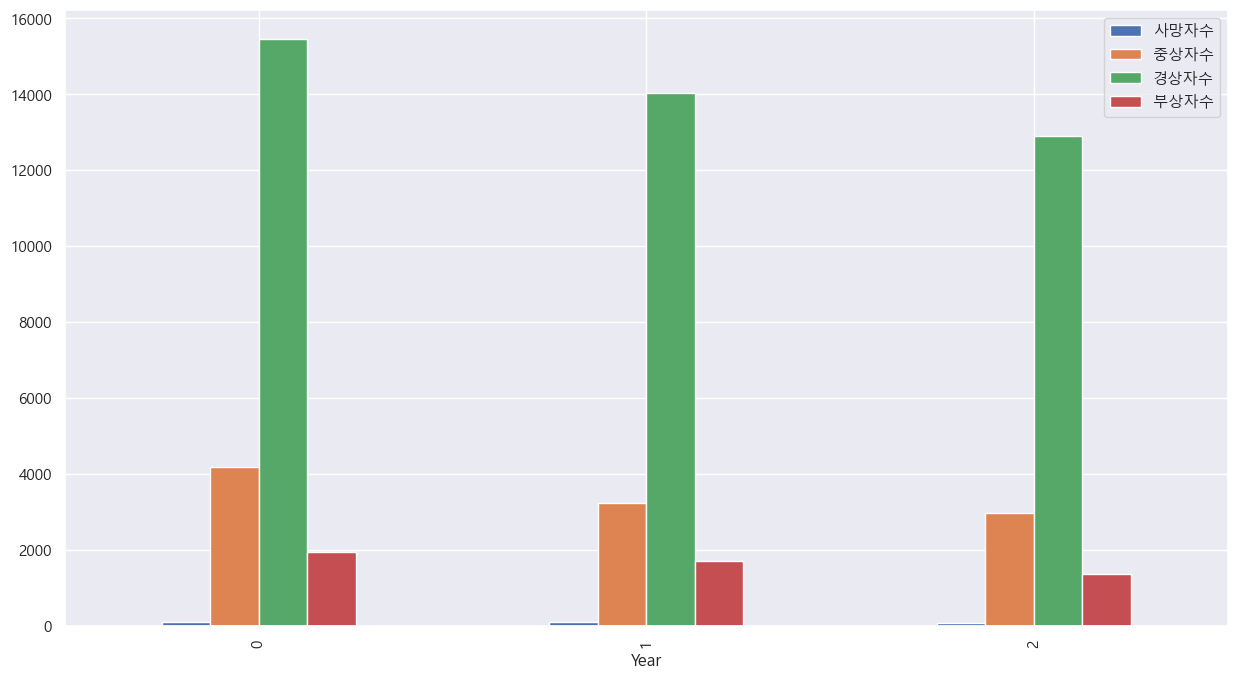

In [68]:
# 한글 깨짐
plt.rcParams['font.family'] = 'Malgun Gothic'

# Year 기준 전체적으로 줄어가는 추세
# Month, Day, 요일은 큰 의미없음
train_new.groupby("Year").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

<Axes: xlabel='기상상태'>

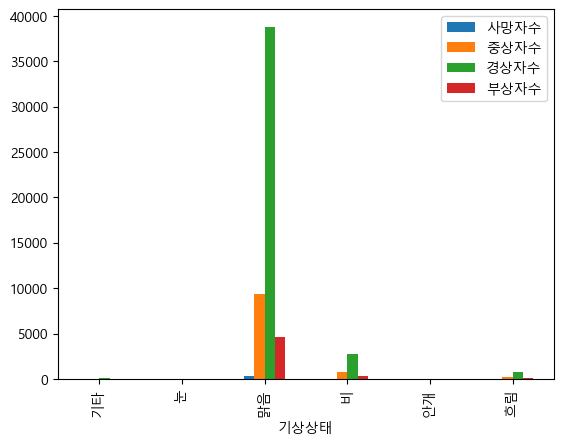

In [37]:
# 맑은 날이 많아서인지 맑은 날 가장 사고가 많음
train_new.groupby("기상상태").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [38]:
# 단일로 - 기타, 교차로-교차로안이 유독 많음
train_new.groupby(["도로형태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
도로형태,,,,,
교차로 - 교차로부근,28,1376,6670,773,27943
교차로 - 교차로안,66,2933,11036,1283,49716
교차로 - 교차로횡단보도내,18,585,945,137,6077
기타 - 기타,9,444,1850,215,8075
단일로 - 고가도로위,2,24,207,14,775
단일로 - 교량,3,48,305,24,1209
단일로 - 기타,178,4849,20719,2501,90683
단일로 - 지하차도(도로)내,1,81,320,39,1414
단일로 - 터널,3,16,102,5,421


In [39]:
# 건조할 경우 전체 사고가 많음
train_new.groupby(["노면상태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
노면상태,,,,,
건조,268,9454,39023,4624,171643
기타,2,20,37,6,237
서리/결빙,0,6,22,8,104
적설,0,0,3,0,9
젖음/습기,37,912,3298,386,15210
침수,1,0,2,1,17


In [20]:

train.groupby(["사고유형 - 세부분류"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
사고유형 - 세부분류,,,,,
공작물충돌,27,121,175,94,1494
기타,79,2724,9672,1503,44929
길가장자리구역통행중,0,100,300,72,1472
도로외이탈 - 기타,0,0,2,2,8
도로외이탈 - 추락,3,3,3,0,54
보도통행중,5,192,311,41,1984
전도전복 - 전도,5,45,56,57,500
전도전복 - 전복,1,7,4,2,59
정면충돌,17,329,908,98,4637


In [21]:
# 안전운전불이행이 사고를 가장 많이 일으킴
train.groupby(["법규위반"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
법규위반,,,,,
과속,22,88,140,15,1095
교차로운행방법위반,1,685,3339,352,13804
기타,19,439,1072,166,5767
보행자보호의무위반,8,517,644,48,4645
불법유턴,6,106,412,52,1878
신호위반,37,1582,3963,378,20547
안전거리미확보,7,963,7076,768,26881
안전운전불이행,191,5255,22354,2845,98092
중앙선침범,15,346,965,117,4892


In [22]:

train.groupby(["가해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 차종,,,,,
개인형이동수단(PM),0,51,92,46,577
건설기계,6,134,498,21,2245
기타불명,0,114,579,367,2674
농기계,0,0,3,1,10
사륜오토바이(ATV),0,3,3,5,29
승용,165,6790,30998,2585,131179
승합,15,463,1366,166,6729
원동기,4,138,333,121,1850
이륜,47,1132,3432,1019,17445


In [23]:

train.groupby(["가해운전자 성별"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 성별,,,,,
기타불명,0,113,589,368,2700
남,263,7912,30955,3615,138670
여,45,2367,10841,1042,45850


<Axes: xlabel='가해운전자 연령'>

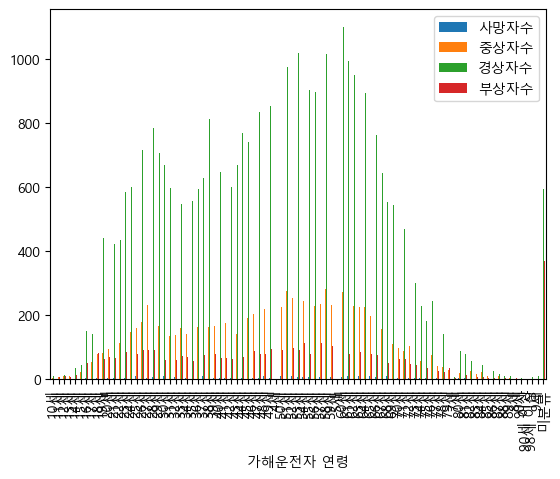

In [28]:
train.groupby(["가해운전자 연령"]).sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [30]:
train.groupby(["가해운전자 상해정도"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 상해정도,,,,,
경상,10,594,7927,153,27004
기타불명,4,428,2334,483,9665
부상신고,3,255,1363,2661,8055
사망,95,18,36,0,1148
상해없음,176,7724,30113,1711,132430
중상,20,1373,612,17,8918


In [32]:
train.groupby(["가해운전자 차종","피해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

사망자수  중상자수  경상자수  부상자수  ECLO
가해운전자 차종    피해운전자 차종                                 
개인형이동수단(PM) 개인형이동수단(PM)     0     3     2     1    22
            기타불명            0     0     0     1     1
            보행자             0    21    33     6   210
            승용              0    17    31    25   203
            승합              0     0     2     1     7
...                       ...   ...   ...   ...   ...
화물          원동기             0    23    38     7   236
            이륜              5   188   288    21  1875
            자전거             3    95   133     9   913
            특수              0     6    12     0    66
            화물             10    93   451    33  1951

[117 rows x 5 columns]

In [29]:
train.columns

Index(['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', 'Hour', 'Year', 'Month', 'Day'],
      dtype='object')